In [44]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('../data/Alcohol_Sales.csv')
series = TimeSeries.from_dataframe(df, 'DATE', 'S4248SM144NCEN')

In [46]:
# 划分训练集和测试集
train, val = series.split_after(pd.Timestamp('20170101'))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# 创建年和月的协变量序列
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=400),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('20170101'))

In [47]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=100,
    dropout=0,
    batch_size=1,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Alcohol_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=12,
    input_chunk_length=12,
    force_reset=True
)

In [48]:
# my_model.fit(train_transformed, covariates=cov_train, val_series=val_transformed, val_covariates=cov_val, verbose=True)  
#Darts的model.fit()中covariates和val_covariates分别变成了future_covariates和val_future_covariates  
my_model.fit(train_transformed, future_covariates=cov_train, val_series=val_transformed, val_future_covariates=cov_val, verbose=True)  


Epoch 9: 100%|██████████| 289/289 [00:04<00:00, 61.53it/s, v_num=logs, train_loss=0.000947, val_loss=0.00269]


RNNModel(model=LSTM, hidden_dim=100, n_rnn_layers=1, dropout=0, training_length=12, batch_size=1, n_epochs=10, optimizer_kwargs={'lr': 0.001}, model_name=Alcohol_RNN, log_tensorboard=True, random_state=42, input_chunk_length=12, force_reset=True)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


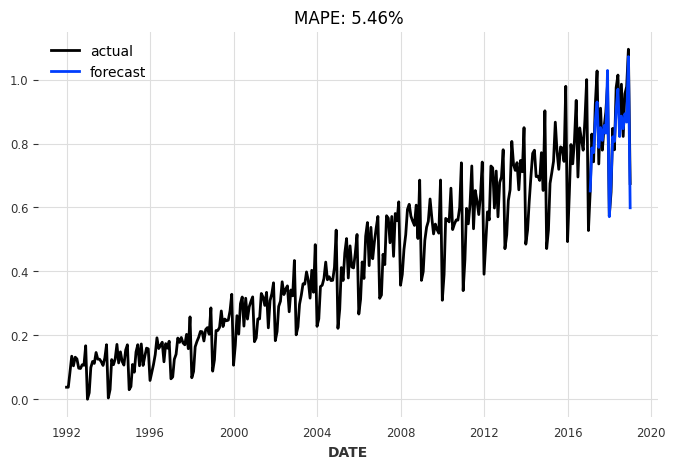

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.16it/s]


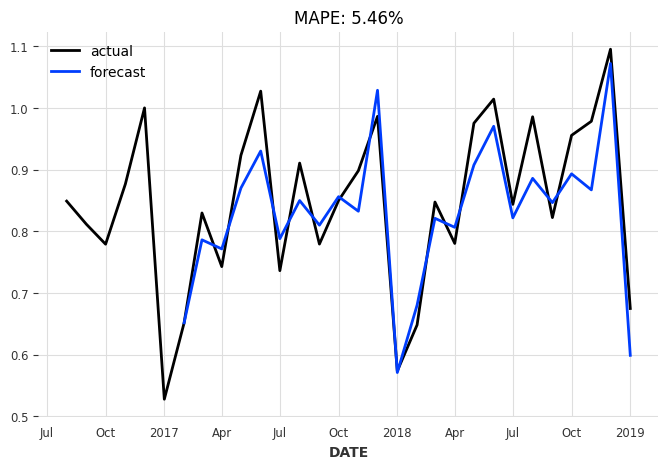

In [49]:
def eval_model(model, lag):  
 # pred_series = model.predict(n=24,covariates=covariates)  
    pred_series = model.predict(n=24,future_covariates=covariates)  
  
    plt.figure(figsize=(8,5))  
    series_transformed[-lag:].plot(label='actual')  
    pred_series.plot(label='forecast')  
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))  
    plt.legend();  
    plt.show()  

eval_model(my_model,0)
eval_model(my_model,30)